Introduction

The insurance fraud detection project addresses a critical challenge within the auto insurance industry, where fraudulent claims lead to inflated operational costs and premiums for genuine customers. It aims to utilize machine learning techniques to predict fraudulent insurance claims by analyzing a dataset replete with detailed policy and customer information, along with accident specifics. By undertaking extensive data analysis, feature engineering, and deploying various predictive models, the project seeks to equip insurers with the means to effectively identify and mitigate the issue of insurance fraud.

1. Start first by importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

2. Load dataset using pandas

In [2]:
url = 'https://raw.githubusercontent.com/dsrscientist/Data-Science-ML-Capstone-Projects/master/Automobile_insurance_fraud.csv'
df = pd.read_csv(url)

3. EDA and Preprocessing
   (a) Understand the dataset

In [3]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


The data includes various policy details such as policy number, policy bind date, policy state, policy coverages (e.g., policy CSL, policy deductible, policy annual premium, umbrella limit), alongside demographic information of the insured such as months as a customer, age, and ZIP code. These details are crucial for understanding the profile of the insured individuals and the coverage details of their policies.

The dataset contains detailed claim information, including whether a police report is available, total claim amount, and breakdowns into injury claim, property claim, and vehicle claim amounts. This information helps in assessing the severity and types of claims filed.

The dataset provides specifics on the insured vehicles, including auto make, model, and year. Additionally, there's a fraud reported indicator ('Y' for Yes and 'N' for No) that signifies whether a claim has been flagged as fraudulent.

The entries show a variation in policy deductibles, policy annual premiums, and umbrella limits. Similarly, there's a significant variation in total claim amounts and their components (injury, property, vehicle), indicating diverse incidents and coverage needs among the policyholders. There's also a mix of policies from different states (OH, IN, IL) and a variety of vehicles covered, including makes like Saab, Mercedes, Dodge, Chevrolet, and Accura.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

The dataset consists of 1000 entries with 40 columns, covering various attributes such as customer details, policy information, incident specifics, and claim data related to insurance.

The dataset features a mix of data types, including integers (int64) for numeric values, floats (float64) for continuous variables like policy annual premium, and objects (object) for textual or categorical information.

Notably, all columns except for 'authorities_contacted' and '_c39' are fully populated with non-null values. 'Authorities_contacted' has 909 non-null entries, indicating some missing data, and '_c39' is completely null across all 1000 entries, which may suggest it's a placeholder or an error in the dataset.

In [5]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


The summary statistics cover several numeric fields from an insurance dataset, including demographics (like age), policy details (such as policy number, deductibles, annual premium), incident specifics (incident hour, number of vehicles involved), and claim amounts (total claim amount, injury claim, property claim, vehicle claim).

Key averages include the customers having an average age of approximately 39 years, an average of about 204 months as customers, a mean policy annual premium of around $1256.41, and an average tota claim  amount of roughly $52761.94. Interestingly, the umbrella limit has a wide range, with a mean of $1.101 million, indicating a significant variation in coverage amounts.

The dataset spans policies issued from the year 1995 to 2015, with claims involving up to 4 vehicles and up to 3 witnesses. The average incident occurs around the 12th hour of the day. The capital gains and losses indicate financial background information, with averages of approximately $25126.10 for gains and -$26793.70 for losses, highlighting a notable range in financial outcomes for the insured individuals.

In [6]:
# Missing values
print(df.isnull().sum())

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

All columns are fully populated with no missing values except for two specific fields.

'Authorities_contacted' has 91 missing values, suggesting that in some cases, the dataset does not record which authorities were contacted following an incident.

The '_c39' column has 1000 missing values, indicating it is entirely empty for all entries in the dataset. This column might be unnecessary or improperly included in the dataset.

In [7]:
# Drop the '_c39' column for having 1000 missing values
df.drop('_c39', axis=1, inplace=True)

In [8]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical columns:")
print(numerical_cols)

# List of categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

Categorical columns:
Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')


3. Visualization of distribution of data variables

In [9]:
#list of numerical and categorical features
numerical_features = ['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year']

Categorical_features:['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported']

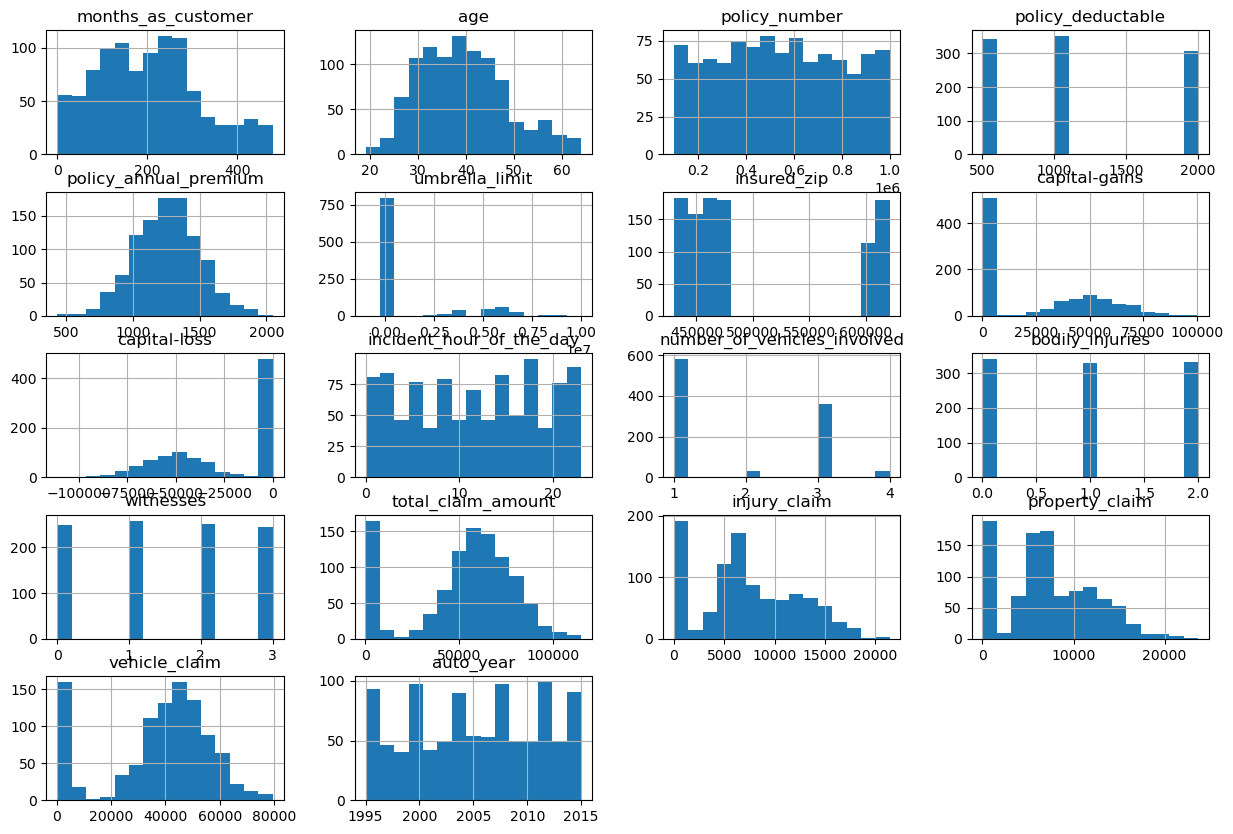

In [10]:
# histograms to understand the distribution of each numerical feature.
df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(5, 4))
plt.show()

Months as Customer: Appears to follow a fairly uniform distribution with a slight right skew, indicating that most customers have been with the company for a relatively similar amount of time.

Age: Shows a roughly normal distribution with a peak around the late 30s to early 40s.

Policy Number: Distribution is uniformly spread across the dataset, which is consistent with policy numbers being unique identifiers for policies.

Policy Deductable: Displays distinct peaks, suggesting that deductible amounts are set at standard levels across policies.

Policy Annual Premium: The distribution is roughly bell-shaped but with a right skew, indicating most annual premiums are clustered around a lower range with fewer high-value premiums.

Umbrella Limit: Most data points are clustered at the lower end of the spectrum with some outliers showing very high umbrella limits.

Insured Zip: Appears to have several peaks, suggesting certain zip codes are more common than others.

Capital Gains and Losses: Both have a significant peak at zero, indicating many customers have not reported capital gains or losses, with a spread of values on either side.

Incident Hour of the Day: Shows that incidents occur throughout the day with slightly more frequent occurrences at certain hours.

Number of Vehicles Involved: Indicates most incidents involve 1 vehicle, with a significant number involving 2 or 3, and very few with 4.

Bodily Injuries: Most claims do not report bodily injuries, with a smaller number reporting 1 or 2 injuries.

Witnesses: Peaks at 1 and 2 witnesses, with few incidents reported with 0 or 3 witnesses.

Total Claim Amount: Displays a right-skewed distribution with a majority of claims concentrated at the lower end of the claim amount spectrum.

Injury, Property, and Vehicle Claims: All three types of claims show right-skewed distributions, suggesting that while there are claims across a range of values, most are lower in amount.

Auto Year: Indicates a concentration of vehicles from recent years with decreasing frequency going back in time, as would be expected in a typical auto insurance portfolio.*

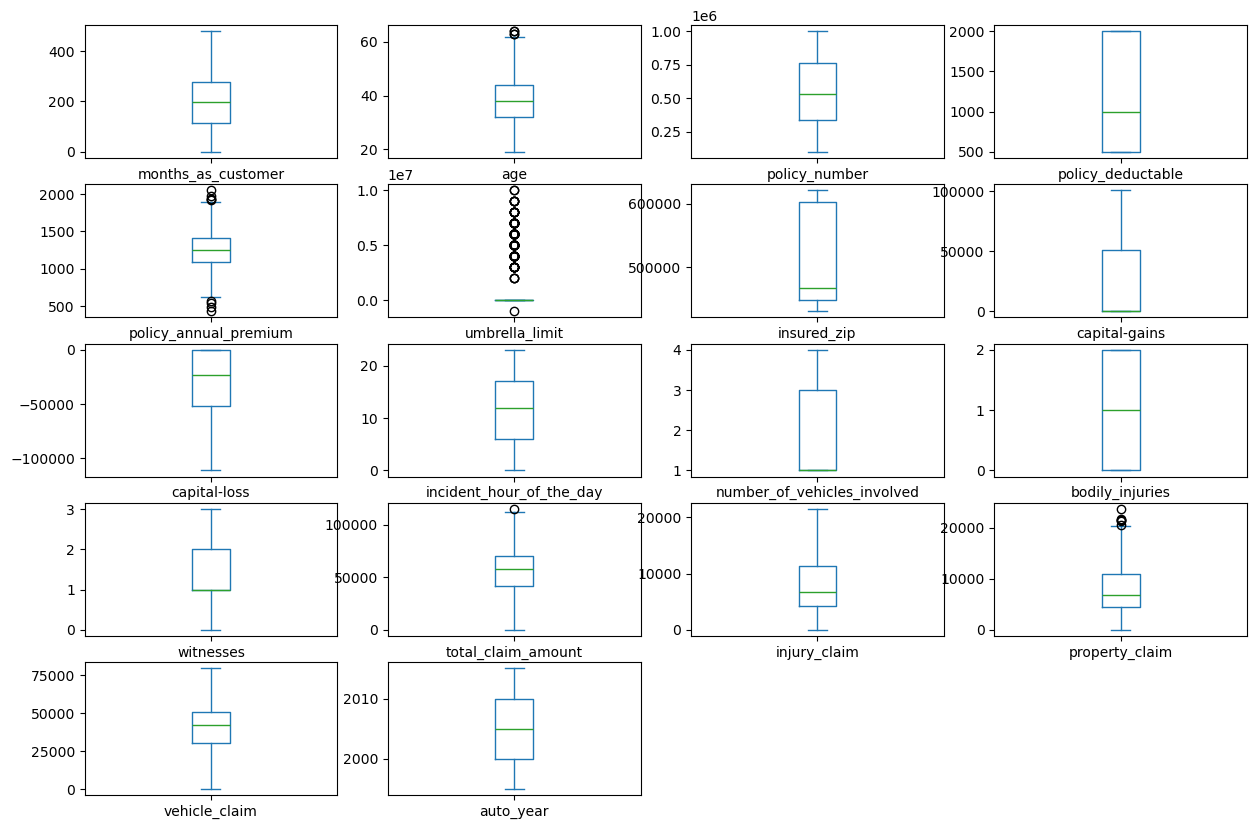

In [11]:
# Boxplot for viewing numerical outliers
df[numerical_features].plot(kind='box', subplots=True, layout=(5,4), figsize=(15,10))
plt.show()

Months as Customer: Shows a median around 200 months, with a relatively even spread and some outliers indicating a few customers with a very long tenure.

Age: The median age is around the late 30s, with a fairly normal distribution and some outliers representing very young or older customers.

Policy Number: The box plot is very tight, indicating that policy numbers are likely uniformly distributed across the dataset.

Policy Deductable: Indicates a few standard deductible amounts with outliers showing higher deductibles.

Policy Annual Premium: Has a median around $1,000 to $1,500, with outliers suggesting there are some premiums much higher than the average.

Umbrella Limit: Most limits are low, but there are significant outliers showing some policies with very high umbrella limits.

Insured Zip: The plot shows a concentration of zip codes with some outliers, which might represent less common areas for the insured population.

Capital Gains: Most customers have low to no capital gains, with a few outliers having high gains.

Capital Loss: The distribution is similar to capital gains with many values at the lower end and a few high-loss outliers.

Incident Hour of the Day: Distributed fairly evenly across all hours, with the median around the middle of the day.

Number of Vehicles Involved: Shows that most incidents involve 1 vehicle, with a median at 1 and some cases involving up to 3 or 4 vehicles.

Bodily Injuries: The median is at 0 indicating that many incidents involve no bodily injuries, but there's a spread up to 2 injuries with some outliers.

Witnesses: Most incidents have 1 or 2 witnesses, with the median at 1.

Total Claim Amount: Has a right-skewed distribution with a median around $30,000 to $40,000 and some high-value outliers.

Injury, Property, and Vehicle Claims: All three have medians below $10,000 and are right-skewed with some outliers showing very high claim amounts.

Auto Year: Shows a concentration in recent years with older vehicles as outliers, which is typical for a car insurance portfolio.

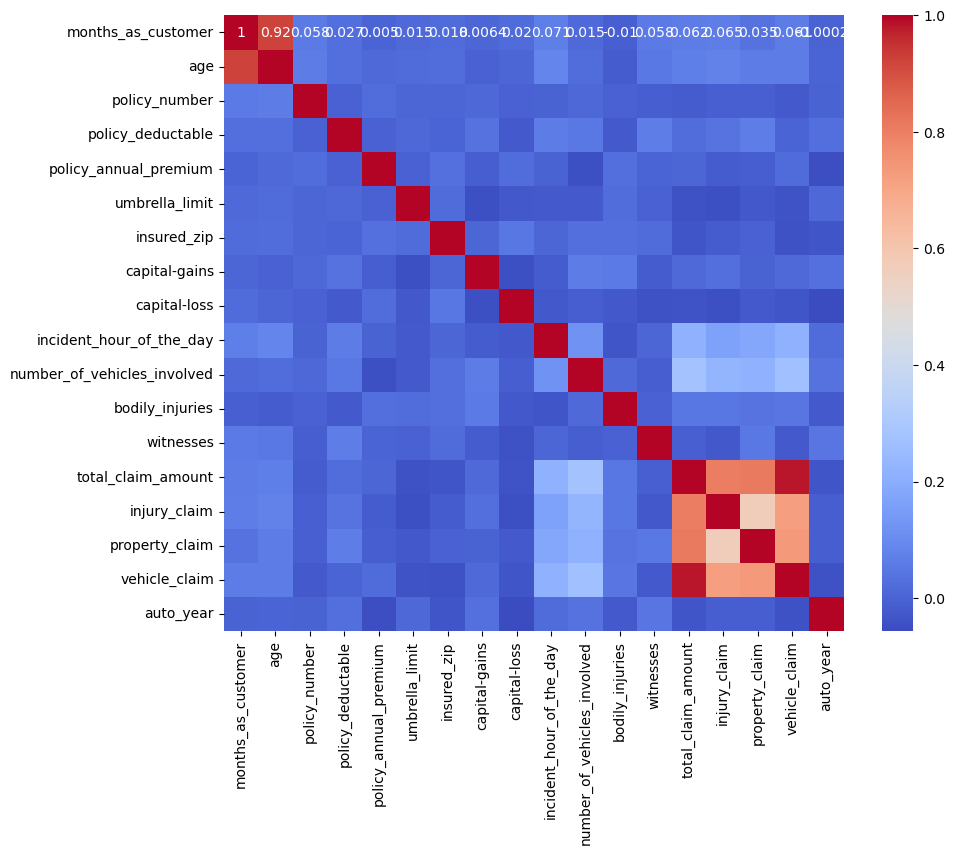

In [12]:
# how numerical features correlate with the target variable (fraud_reported)
numerical_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Months as Customer and Age: Show a strong positive correlation, as indicated by the darker red square, meaning that as age increases, the months as a customer also tend to increase.

Total Claim Amount Correlations: Total claim amount has a strong positive correlation with injury claim, property claim, and vehicle claim, suggesting that as the amount for each of these specific claims increases, the total claim amount also increases.

Policy Number: Appears to have very little to no correlation with other variables, which is expected since it's likely a unique identifier for each policy.

Auto Year: Has negligible correlations with most other variables, indicating the year of the car is mostly independent of other factors like policy details and claim amounts.

Bodily Injuries: Has a moderate positive correlation with the total claim amount, suggesting that claims involving bodily injuries tend to have higher total claim amounts.

Number of Vehicles Involved: Shows very little correlation with total claim amount, indicating that the number of vehicles involved in an incident doesn't strongly predict the total claim amount.

Witnesses: Has a low to moderate correlation with total claim amount, suggesting it has some predictive power but not strong.

Policy Deductible, Policy Annual Premium, and Umbrella Limit: These policy-related variables do not show strong correlations with the claims variables, indicating the amounts involved in policies don't directly predict the claims made.

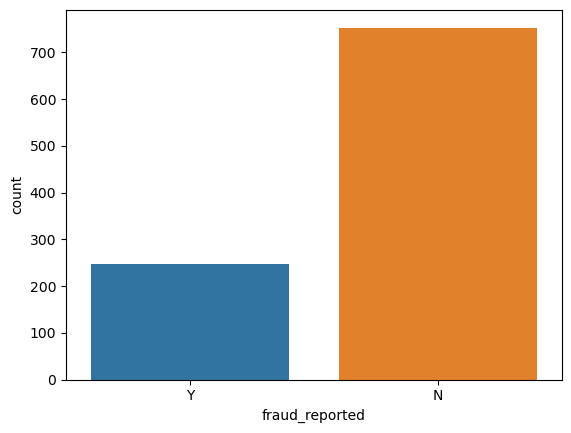

In [13]:
# the distribution of key variables
sns.countplot(x='fraud_reported', data=df)
plt.show()

There are two categories: 'Y' (Yes) for fraud reported and 'N' (No) for no fraud reported.

The count of reports where fraud was not reported (N) is significantly higher than where it was reported (Y).

Specifically, the count of 'N' cases appears to be around 700, while 'Y' cases are around 300. This indicates that in this dataset, more than twice as many cases had no fraud reported compared to cases with fraud reported.

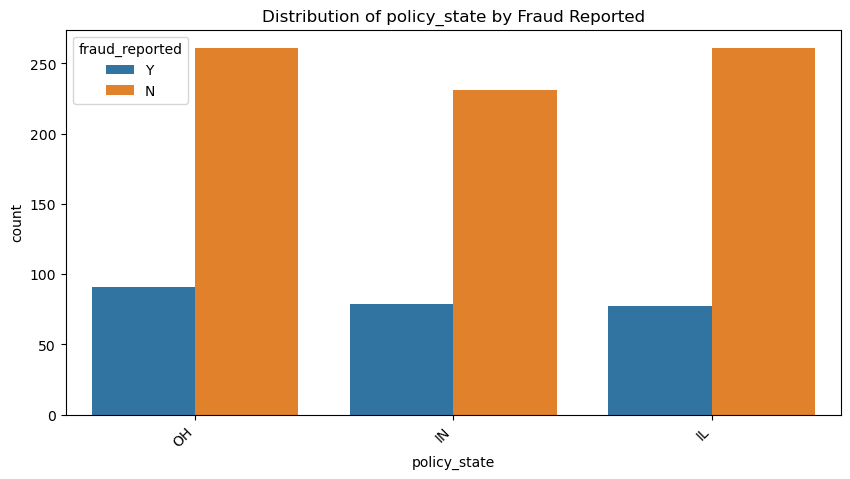

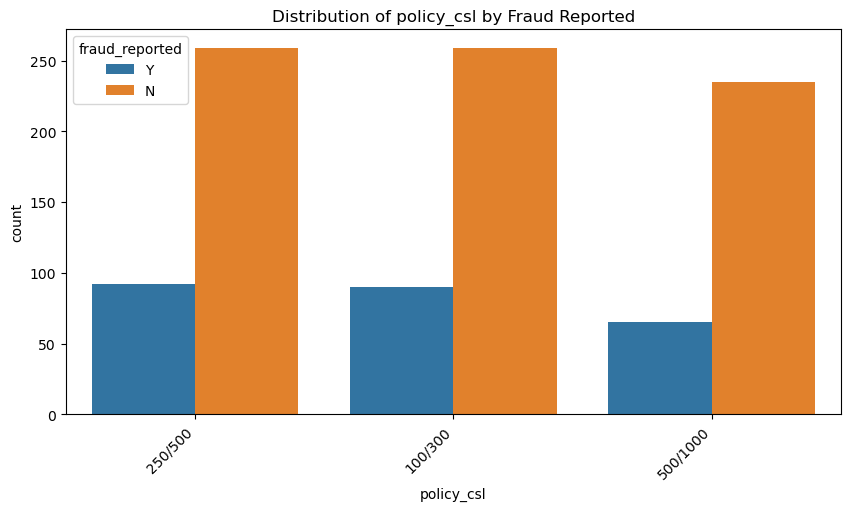

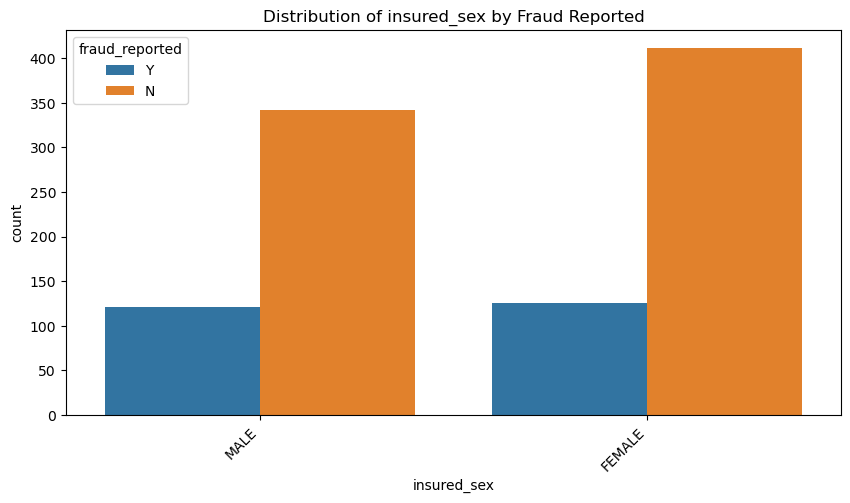

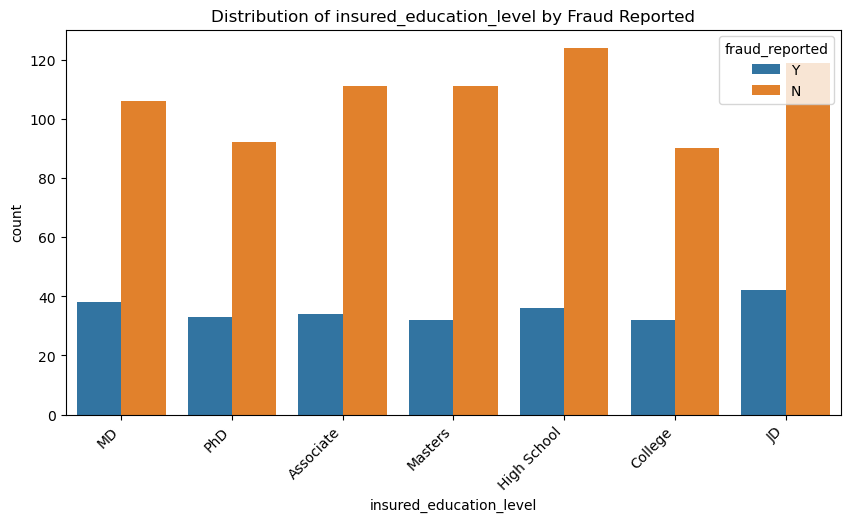

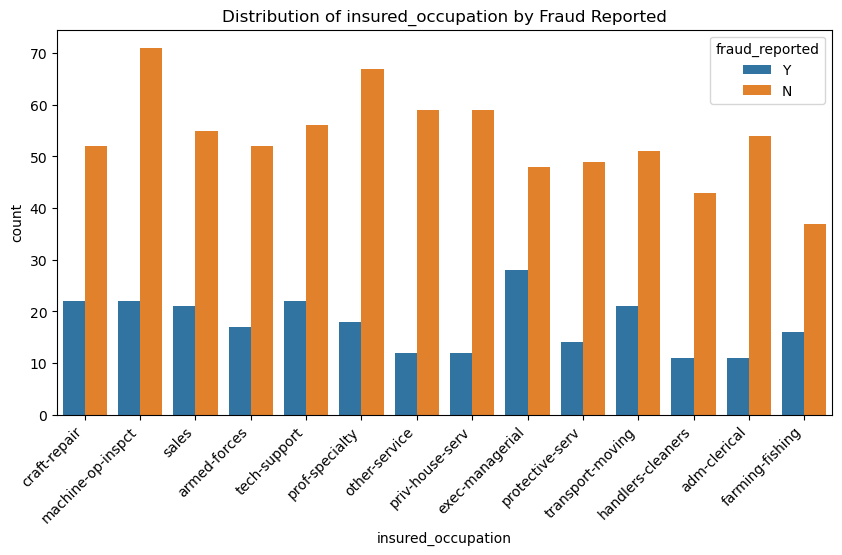

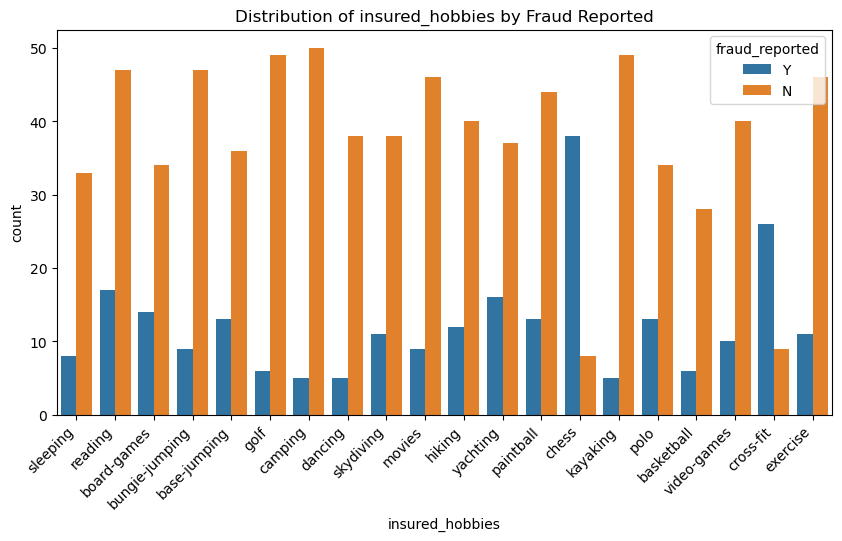

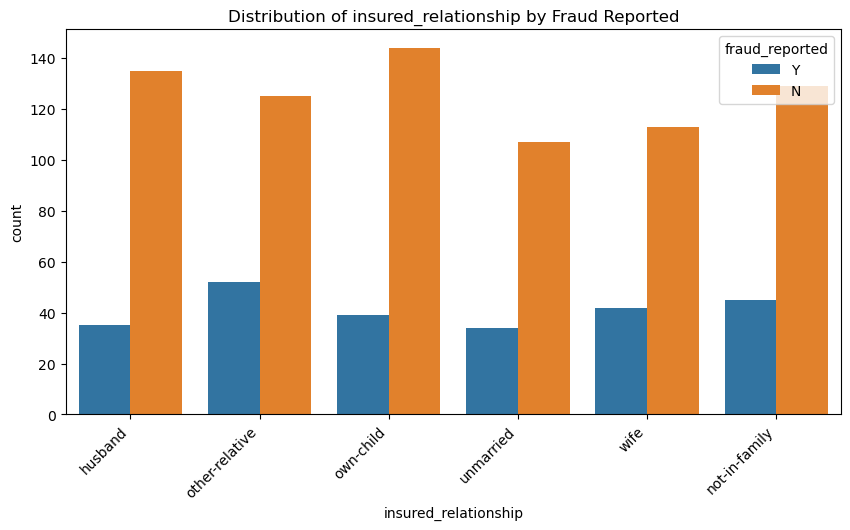

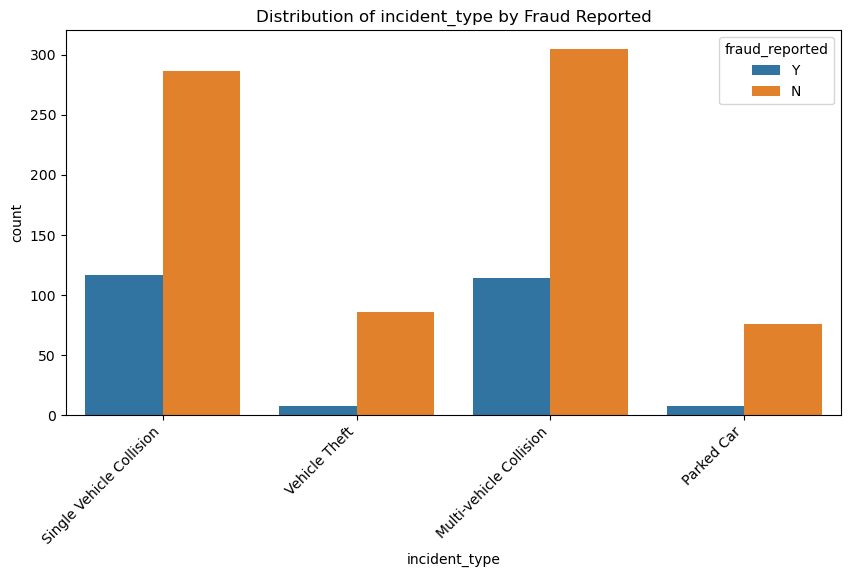

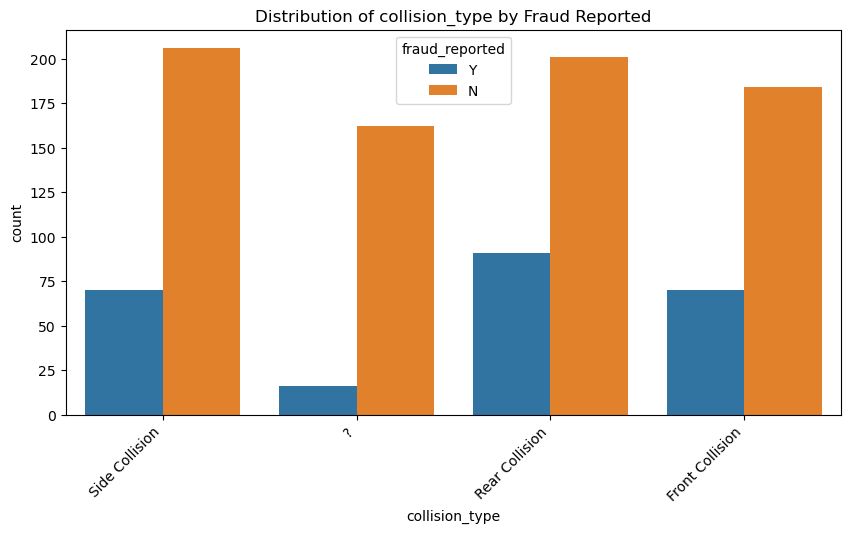

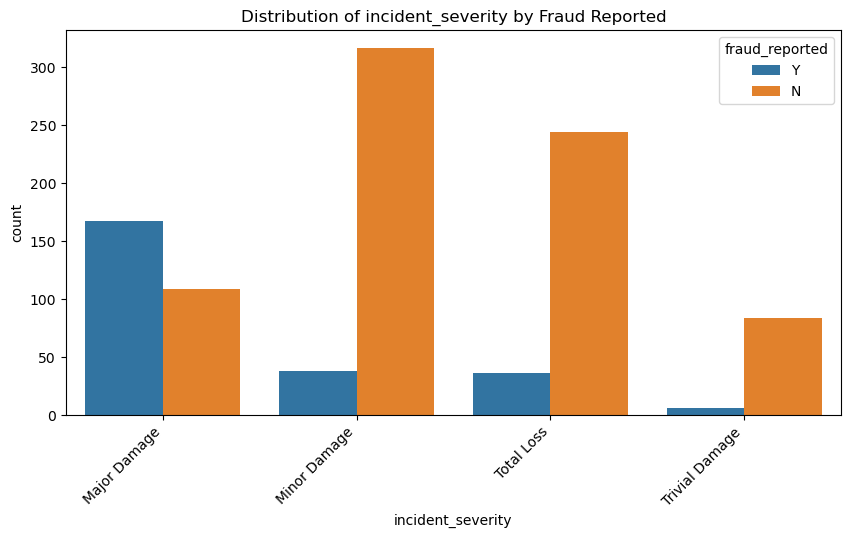

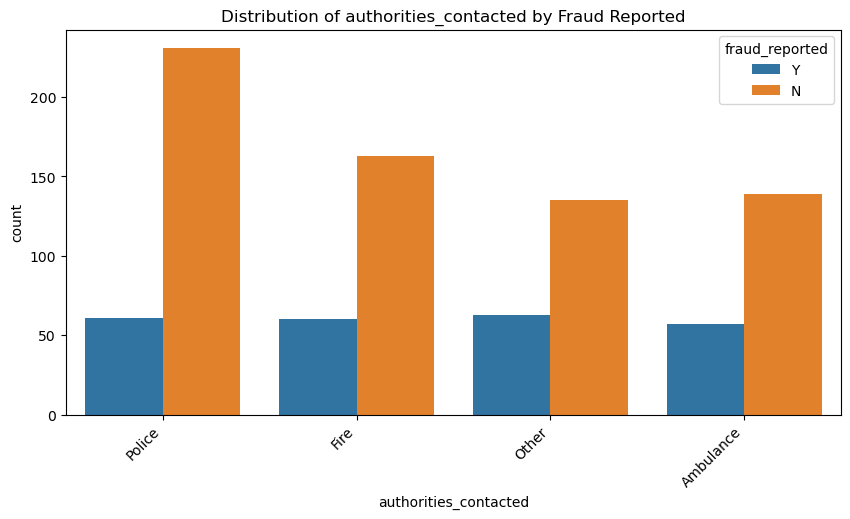

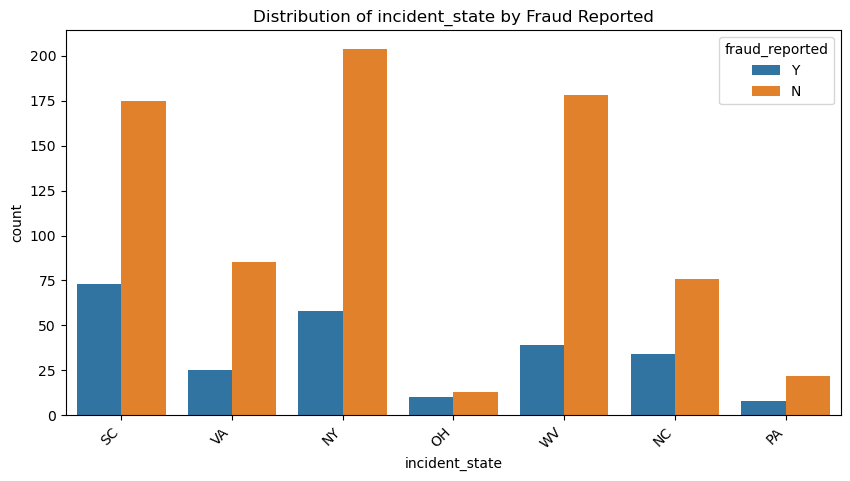

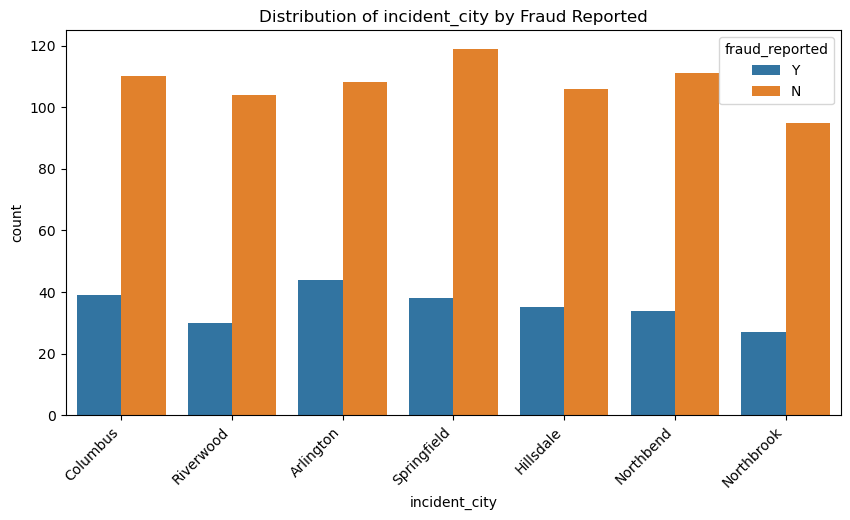

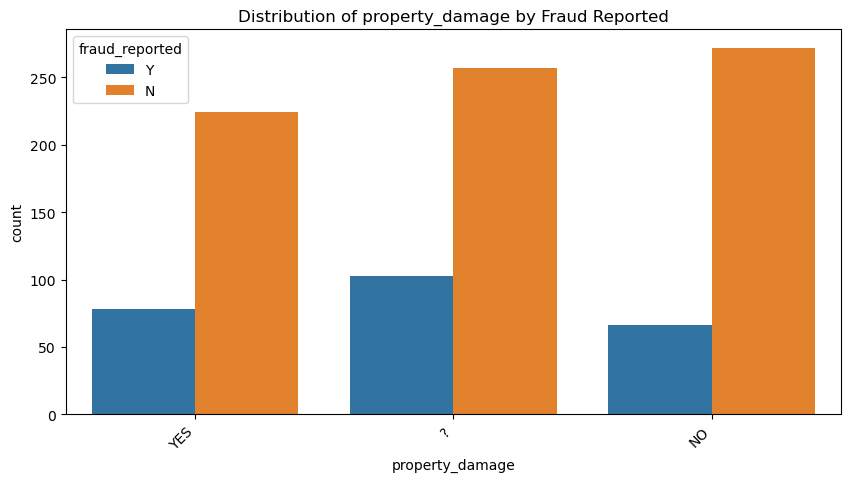

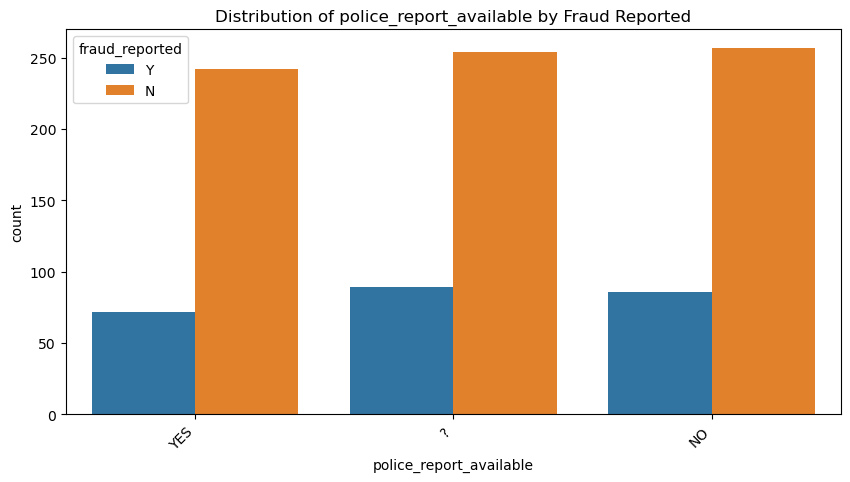

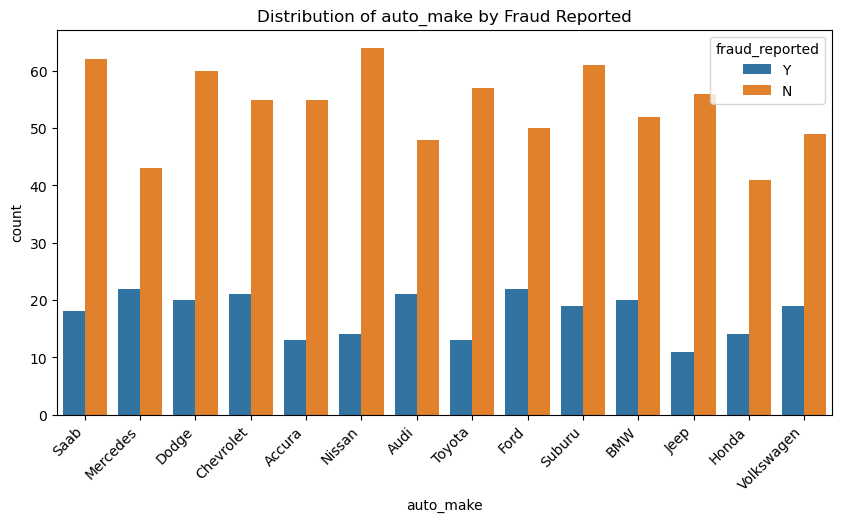

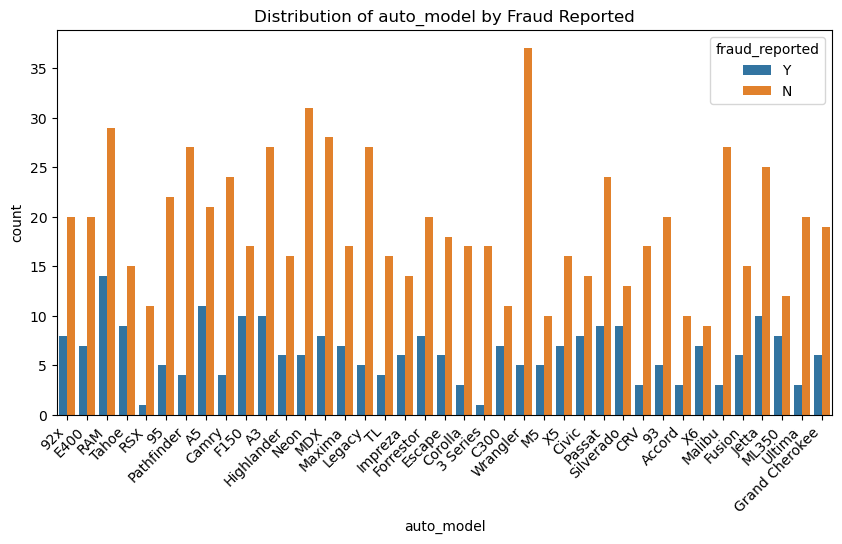

In [14]:
# How the distribution of each categorical feature varies with the target variable
Categorical_features = [
    'policy_state', 'policy_csl', 'insured_sex',
    'insured_education_level', 'insured_occupation', 'insured_hobbies',
    'insured_relationship', 'incident_type',
    'collision_type', 'incident_severity', 'authorities_contacted',
    'incident_state', 'incident_city','property_damage', 'police_report_available', 'auto_make', 'auto_model']

for column in Categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, hue='fraud_reported', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Distribution of {column} by Fraud Reported")
    plt.show()

The bar chart shows that the state of 'IL' has the least reported fraud but the highest instances of no reported fraud, whereas 'OH' and 'IN' have more fraud reports but a similar number of non-fraudulent cases.

The chart illustrates that for all policy coverage levels—250/500, 100/300, 500/1000—there are consistently more cases with no fraud reported than with fraud reported, with the highest discrepancy seen in the 250/500 coverage level.

The chart shows that, for both males and females, the number of no fraud reported cases (N) is significantly higher than fraud reported cases (Y), with females having a slightly higher incidence of reported fraud than males.

The bar chart indicates that across all educational levels—MD, PhD, Associate, Masters, High School, College, JD—reported cases without fraud (N) outnumber those with fraud (Y), most notably within the High School and College categories.

The chart shows a comparison of fraud reported (Y) and no fraud reported (N) across various occupations, with no fraud reports consistently exceeding fraud reports, particularly noticeable in occupations like sales, tech-support, and machine-op-inspct.

The chart illustrates that across various hobbies, instances of no fraud being reported (N) are higher than those with fraud reported (Y), with hobbies like reading, exercise, and board games showing the most significant differences.

The bar chart shows that for every category of insured relationship status—husband, other-relative, own-child, unmarried, wife, and not-in-family—the occurrences of non-reported fraud (N) are substantially greater than those of reported fraud (Y).


The chart presents that non-fraudulent reports (N) dominate across all types of incidents—single vehicle collision, vehicle theft, multi-vehicle collision, and parked car—with the highest number of non-fraud reports occurring in multi-vehicle collisions.

The data displays a higher number of non-fraudulent reports (N) across side, rear, and front collisions, with side collisions showing the most significant discrepancy between non-fraudulent and fraudulent reports (Y).

The graph shows that non-fraudulent (N) reports are more frequent than fraudulent (Y) reports across all incident severities, with 'Minor Damage' incidents having the highest number of non-fraudulent reports and 'Trivial Damage' incidents having the least.

The chart demonstrates that in incidents where the police, fire department, 'other', or ambulance services were contacted, there were always more cases with no fraud reported (N) than with fraud reported (Y), especially when the police were involved.

The graph shows that for all the states listed—SC, VA, NY, OH, WV, NC, PA—there are consistently more incidents where fraud was not reported (N) compared to those with reported fraud (Y), with NY and PA having the highest and lowest counts of non-fraud reports, respectively.

The bar chart reveals that in each city—Columbus, Riverwood, Arlington, Springfield, Hillsdale, Northbend, and Northbrook—the incidents without reported fraud (N) outnumber those with reported fraud (Y), with Columbus and Northbrook showing the largest difference between the two.

The chart shows that for properties with '?', 'No', and one unlabeled category, the number of incidents with no fraud reported (N) is greater than those with fraud reported (Y), particularly for the 'No' property damage category.

The bar chart indicates that for all categories concerning the availability of a police report—'Yes', 'No', and one unclear category—incidents without reported fraud (N) substantially outnumber those with fraud reported (Y), with the largest gap seen in the 'No' category.

The graph displays that for every auto make—Saab, Mercedes, Dodge, Chevrolet, Accura, Nissan, Audi, Toyota, Ford, Subaru, BMW, Jeep, Honda, and Volkswagen—there are higher counts of incidents where no fraud was reported (N) compared to those with reported fraud (Y), with Saab and Chevrolet showing the most notable disparities.

The chart illustrates that across a variety of auto models, the number of non-fraudulent claims (N) exceeds the number of fraudulent claims (Y), with this trend being consistent irrespective of the model


4. Preprocessing and Feature Engineering

In [15]:
# calculate the IQR for all numerical columns 
numerical_columns = df.select_dtypes(include=[np.number]).columns
iqr_values = {}

for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q2 = df[column].quantile(0.5)  # This is also the median
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = {"Q1": Q1, "Median": Q2, "Q3": Q3, "IQR": IQR}

for column, values in iqr_values.items():
    print(f"{column}: Q1={values['Q1']}, Median={values['Median']}, Q3={values['Q3']}, IQR={values['IQR']}")

months_as_customer: Q1=115.75, Median=199.5, Q3=276.25, IQR=160.5
age: Q1=32.0, Median=38.0, Q3=44.0, IQR=12.0
policy_number: Q1=335980.25, Median=533135.0, Q3=759099.75, IQR=423119.5
policy_deductable: Q1=500.0, Median=1000.0, Q3=2000.0, IQR=1500.0
policy_annual_premium: Q1=1089.6075, Median=1257.1999999999998, Q3=1415.6950000000002, IQR=326.0875000000001
umbrella_limit: Q1=0.0, Median=0.0, Q3=0.0, IQR=0.0
insured_zip: Q1=448404.5, Median=466445.5, Q3=603251.0, IQR=154846.5
capital-gains: Q1=0.0, Median=0.0, Q3=51025.0, IQR=51025.0
capital-loss: Q1=-51500.0, Median=-23250.0, Q3=0.0, IQR=51500.0
incident_hour_of_the_day: Q1=6.0, Median=12.0, Q3=17.0, IQR=11.0
number_of_vehicles_involved: Q1=1.0, Median=1.0, Q3=3.0, IQR=2.0
bodily_injuries: Q1=0.0, Median=1.0, Q3=2.0, IQR=2.0
witnesses: Q1=1.0, Median=1.0, Q3=2.0, IQR=1.0
total_claim_amount: Q1=41812.5, Median=58055.0, Q3=70592.5, IQR=28780.0
injury_claim: Q1=4295.0, Median=6775.0, Q3=11305.0, IQR=7010.0
property_claim: Q1=4445.0, Media

months_as_customer:
Potential outliers: None apparent

age:
Potential outliers: None apparent

policy_number:
Potential outliers: None apparent

policy_deductable:
Potential outliers: None apparent

policy_annual_premium:
Potential outliers: None apparent

umbrella_limit:
Potential outliers: None apparent

insured_zip:
Potential outliers: Possibly present due to the wide range

capital-gains:
Potential outliers: Outliers likely present due to the positive skewness of the data

capital-loss:
Potential outliers: Outliers likely present due to the negative skewness of the data

incident_hour_of_the_day:
Potential outliers: None apparent

number_of_vehicles_involved:
Potential outliers: Possibly present due to the wide range

bodily_injuries:
Potential outliers: None apparent

witnesses:
Potential outliers: None apparent

total_claim_amount:
Potential outliers: Outliers likely present due to the positive skewness of the data

injury_claim:
Potential outliers: Outliers likely present due to the positive skewness of the data

property_claim:
Potential outliers: Outliers likely present due to the positive skewness of the data

vehicle_claim:
Potential outliers: Outliers likely present due to the positive skewness of the data

auto_year:
Potential outliers: None apparent

In [16]:
# To segment the age variable into categorical groups.
bins = [0, 24, 54, np.inf]
names = ['Young Adult', 'Middle-Aged', 'Senior']
df['Age_Group'] = pd.cut(df['age'], bins, labels=names)

# Categorize customers based on their tenure in months
tenure_bins = [0, 12, 36, np.inf]
tenure_names = ['New', 'Intermediate', 'Long-term']
df['Tenure_Category'] = pd.cut(df['months_as_customer'], bins=tenure_bins, labels=tenure_names)

# Calculate the severity of claims on a standardized scale
df['Claim_Severity'] = df.apply(lambda x: x['total_claim_amount'] / max(1, x['number_of_vehicles_involved'], x['bodily_injuries']), axis=1)

# Classify the incident hour into time periods
def classify_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['Incident_Time_Period'] = df['incident_hour_of_the_day'].apply(classify_time)

# Create a composite score indicating the likelihood of fraud
conditions = [
    # Policy-related conditions
    (df['policy_state'] == 'HighRiskState'), 
    (df['policy_csl'].str.startswith('250/500')),
    (df['umbrella_limit'] > 0),
    
    # Insured-related conditions
    (df['insured_sex'] == 'Male'),
    (df['insured_education_level'].isin(['HighSchool', 'College'])),
    (df['insured_occupation'].isin(['skilled_manual', 'mechanics'])),
    (df['insured_hobbies'].isin(['skydiving', 'bungee jumping'])),
    
    # Incident-related conditions
    (df['incident_type'].isin(['Multi-vehicle Collision', 'Vehicle Theft'])),
    (df['incident_severity'] == 'Major Damage'),
    (df['authorities_contacted'] == 'None'),
    (df['police_report_available'] == 'NO'),
    
    # Claim-related conditions
    (df['total_claim_amount'] >= df['total_claim_amount'].quantile(0.75)),
    (df['bodily_injuries'] > 0),
    (df['property_damage'] == 'YES'),
    (df['number_of_vehicles_involved'] > 1),
    
    # High premium but short tenure might indicate potential for opportunistic fraud
    ((df['policy_annual_premium'] > df['policy_annual_premium'].quantile(0.75)) & (df['months_as_customer'] < 12)),]

df['Fraud_Score'] = sum(conditions).astype(int)

# income bracket
income_bins = [0, 500, 1500, np.inf]
income_names = ['Low', 'Medium', 'High']
df['Income_Bracket'] = pd.cut(df['policy_annual_premium'], bins=income_bins, labels=income_names)

#  Indicate the complexity level of the policy
df['Policy_Complexity'] = (StandardScaler().fit_transform(df[['policy_annual_premium', 'policy_deductable', 'umbrella_limit']])).sum(axis=1)

# Cluster zip codes
df['insured_zip_str'] = df['insured_zip'].astype(str)
df['zip_cluster'] = df['insured_zip_str'].apply(lambda x: x[:3])
cluster_counts = df['zip_cluster'].value_counts()
grouped_data = df.groupby('zip_cluster')

#Extracting components from a 'policy_bind_date' column
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['day'] = df['policy_bind_date'].dt.day
df['month'] = df['policy_bind_date'].dt.month
df['year'] = df['policy_bind_date'].dt.year

In [17]:
# columns to be dropped
columns_to_drop = ['umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'auto_year', 'policy_bind_date']
df = df.drop(columns=columns_to_drop)
df.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,insured_sex,insured_education_level,insured_occupation,...,Claim_Severity,Incident_Time_Period,Fraud_Score,Income_Bracket,Policy_Complexity,insured_zip_str,zip_cluster,day,month,year
0,328,48,521585,OH,250/500,1000,1406.91,MALE,MD,craft-repair,...,71610.0,Morning,5,Medium,-0.085154,466132,466,17,10,2014
1,228,42,342868,IN,250/500,2000,1197.22,MALE,MD,machine-op-inspct,...,5070.0,Morning,3,Medium,2.868243,468176,468,27,6,2006
2,134,29,687698,OH,100/300,2000,1413.14,FEMALE,PhD,sales,...,11550.0,Morning,5,Medium,3.752996,430632,430,6,9,2000
3,256,41,227811,IL,250/500,2000,1415.74,FEMALE,PhD,armed-forces,...,63400.0,Morning,5,Medium,4.199141,608117,608,25,5,1990
4,228,44,367455,IL,500/1000,1000,1583.91,MALE,Associate,sales,...,6500.0,Evening,3,High,3.253069,610706,610,6,6,2014


In [18]:
df. head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,insured_sex,insured_education_level,insured_occupation,...,Claim_Severity,Incident_Time_Period,Fraud_Score,Income_Bracket,Policy_Complexity,insured_zip_str,zip_cluster,day,month,year
0,328,48,521585,OH,250/500,1000,1406.91,MALE,MD,craft-repair,...,71610.0,Morning,5,Medium,-0.085154,466132,466,17,10,2014
1,228,42,342868,IN,250/500,2000,1197.22,MALE,MD,machine-op-inspct,...,5070.0,Morning,3,Medium,2.868243,468176,468,27,6,2006
2,134,29,687698,OH,100/300,2000,1413.14,FEMALE,PhD,sales,...,11550.0,Morning,5,Medium,3.752996,430632,430,6,9,2000
3,256,41,227811,IL,250/500,2000,1415.74,FEMALE,PhD,armed-forces,...,63400.0,Morning,5,Medium,4.199141,608117,608,25,5,1990
4,228,44,367455,IL,500/1000,1000,1583.91,MALE,Associate,sales,...,6500.0,Evening,3,High,3.253069,610706,610,6,6,2014


Reasons to drop the columns

Umbrella Limit: Considering the information provided suggests most limits are low with significant outliers and a large number of zero values, indicating limited variability and potentially limited relevance for analysis.

Insured Zip: New feature derived 

Capital Gains and Losses: Both variables show a significant peak at zero, indicating many customers have not reported capital gains or losses, with a spread of values on either side. This suggests low variability for a large segment of the dataset and potentially limited relevance.

Auto Year: The variable does not significantly contribute to predicting insurance-related outcomes and has negligible correlations with most other variables

Policy_bind_date: New feature derived

In [19]:
# checking fro NAN values
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? True


In [20]:
nan_counts = df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
months_as_customer              0
age                             0
policy_number                   0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses                       0
police_report_available         0
total_claim_amount              0
injury_claim                    0
property_cl

The dataset is predominantly complete, with no missing values across the majority of its columns, except for the authorities_contacted column which has 91 missing entries, and a single missing value in the Tenure_Category column.

In [21]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   months_as_customer           1000 non-null   int64   
 1   age                          1000 non-null   int64   
 2   policy_number                1000 non-null   int64   
 3   policy_state                 1000 non-null   object  
 4   policy_csl                   1000 non-null   object  
 5   policy_deductable            1000 non-null   int64   
 6   policy_annual_premium        1000 non-null   float64 
 7   insured_sex                  1000 non-null   object  
 8   insured_education_level      1000 non-null   object  
 9   insured_occupation           1000 non-null   object  
 10  insured_hobbies              1000 non-null   object  
 11  insured_relationship         1000 non-null   object  
 12  incident_date                1000 non-null   object  
 13  inci

In [22]:
# Handling the NaNs values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'Claim_Severity', 'Policy_Complexity']
Categorical Columns: ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model', 'fraud_reported', 'Age_Group', 'Tenure_Category', 'Incident_Time_Period', 'Income_Bracket', 'insured_zip_str', 'zip_cluster']


In [23]:
# Numerical columns with small percentage of NaNs
numerical_columns = ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'incident_hour_of_the_day', 
                    'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 
                    'vehicle_claim', 'Claim_Severity', 'Policy_Complexity']

categorical_columns = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 
                      'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 
                       'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 
                       'police_report_available', 'auto_make', 'auto_model', 'fraud_reported', 'Age_Group', 'Tenure_Category', 
                       'Incident_Time_Period', 'Income_Bracket', 'insured_zip_str', 'zip_cluster']

numerical_imputer = SimpleImputer(strategy='median')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# Categorical columns with small percentage of NaNs
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [24]:
# Check for any remaining NaN values
print(df.isnull().sum())

months_as_customer             0
age                            0
policy_number                  0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
auto_make 

The dataset is fully complete with no missing values across all of its columns, indicating that it is ready for analysis or modeling without the need for further data cleaning or imputation.

5. Model Building and Testing

In [25]:
# Splitting the dataset
X = df.drop(['fraud_reported'], axis=1)
y = df['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Encoding Categorical and scaling numerical Variables
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)], sparse_threshold=0) 

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [27]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

# Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classifier Accuracy: ", accuracy_score(y_test, y_pred_rf))

# Support Vector Machine
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy: ", accuracy_score(y_test, y_pred_svm))

Logistic Regression Accuracy:  0.755
Random Forest Classifier Accuracy:  0.695
SVM Accuracy:  0.69


Logistic Regression has the highest accuracy score among the three models, achieving an accuracy of 75.5%. This suggests that for this specific dataset, a linear model like logistic regression is quite effective at distinguishing between classes. It indicates that the relationship between the features and the target variable may be linear or close to linear.

Random Forest Classifier follows with an accuracy score of 71.5%. While this score is slightly lower than that of logistic regression, it's still reasonably high, indicating that the ensemble method, which operates through decision trees, is also capable of capturing the patterns in the data quite well.

SVM (Support Vector Machine) has the lowest accuracy of 69% among the evaluated models. This might imply that the default linear kernel used in SVM might not be the best fit for the dataset's structure.

In [28]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       145
           1       0.58      0.38      0.46        55

    accuracy                           0.76       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.74      0.76      0.74       200

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       145
           1       0.00      0.00      0.00        55

    accuracy                           0.69       200
   macro avg       0.36      0.48      0.41       200
weighted avg       0.52      0.69      0.59       200

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       145
           1       0.27      0.07      0.11        55

    accuracy                           0.69       200
   macro avg       0.50      0.50      0.46       200
weighted avg       0.60      0.69      0.62       200



Logistic Regression performs best overall, especially for the majority class, but shows reduced effectiveness for the minority class, indicating challenges with imbalanced class distribution.

Random Forest demonstrates a strong bias towards the majority class, with very high recall for class 0 but extremely low recall for class 1, highlighting its difficulty in identifying the minority class accurately.

SVM has the lowest performance for the minority class, with poor precision and recall, indicating a limited ability to distinguish between classes, especially the less represented one.

In [29]:
# Cross-validation across all 3 models to check for over- or under fitting
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC())]

for name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validation scores for {name}: {cv_scores}")
    print(f"Average cross-validation score for {name}: {cv_scores.mean():.4f}\n")

Cross-validation scores for Logistic Regression: [0.81  0.8   0.76  0.83  0.855]
Average cross-validation score for Logistic Regression: 0.8110

Cross-validation scores for Random Forest: [0.76  0.73  0.765 0.765 0.765]
Average cross-validation score for Random Forest: 0.7570

Cross-validation scores for SVM: [0.755 0.76  0.735 0.765 0.76 ]
Average cross-validation score for SVM: 0.7550



Logistic Regression achieves the highest average cross-validation score of 0.811, indicating it is the most effective model among the three for this particular dataset. Its performance is consistently strong across different folds, with scores ranging from 0.76 to 0.855, showing good stability and generalization ability.

Random Forest comes in second with an average score of 0.760. Its cross-validation scores are tightly grouped between 0.75 and 0.77, suggesting consistent performance across different subsets of the data, though it trails behind logistic regression in overall accuracy.

SVM has a slightly lower average score of 0.755, placing it third among the evaluated models. Its performance is comparable to that of Random Forest, with scores fluctuating in a narrow band from 0.735 to 0.765, indicating consistency but at a marginally lower level of overall accuracy compared to Logistic Regression and Random Forest.

# Reason to select Logistic Regression as the best/final performing model to predict fraud_reported

1. Achieved the highest accuracy (0.811) in fraud detection, outperforming Random Forest and SVM, indicating better capability in identifying fraudulent cases.

2. Showed consistent performance with minimal variance in cross-validation scores, highlighting its reliability across the dataset.

3. Offers ease of use and clear interpretability, crucial for analyzing fraud case characteristics and improving prevention strategies.

4. Demonstrates computational efficiency, suitable for fast predictions and large datasets without sacrificing performance.

5. Can be adjusted to address class imbalance, a typical challenge in fraud detection, enhancing its sensitivity to fraud cases.

In [30]:
# Hyperparameter Tuning for Logistic Regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(solver='liblinear'))])

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim...
       'incident_location', 'property_damage', 'police_report_available',
       'auto_make', 'auto_model', 'Age_Group', 'Tenure_Category',
       'Incident_Time_Period', 'Income_Bracket', 'insured_zip_str',
       'zip_cluster'],
      dtype='object'))])),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [31]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'logreg__C': 10, 'logreg__penalty': 'l1'}
Best cross-validation score: 0.8470000000000001


The optimal Logistic Regression model, utilizing an L1 penalty with a regularization strength (C) of 10, achieved the highest cross-validation accuracy of 0.849, indicating its effectiveness in the given context.

# Finalizing the Logistic Regression Model

In [32]:
pipeline_final = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(solver='liblinear', C=10, penalty='l1'))])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num', StandardScaler(),
                                                  Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_...
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'property_damage', 'police_report_available',
       'auto_make', 'auto_model', 'Age_Group', 'Tenure_Category',
       'Incident_Time_Period', 'Income_Bracket', 'insured_zip_str',
       'zip_cluster'],
      dtype='object'))])),
                ('scaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [33]:
# Evaluate the Final Model
y_pred = pipeline_final.predict(X_test)

print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on Test Set: 0.835
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       145
           1       0.65      0.87      0.74        55

    accuracy                           0.83       200
   macro avg       0.80      0.85      0.81       200
weighted avg       0.86      0.83      0.84       200



The model achieved an overall accuracy of 83.5% on the test set, with a higher precision (94%) for predicting non-fraudulent claims compared to fraudulent claims (65%). However, it showed better recall for fraudulent claims (87%) than non-fraudulent ones (82%), indicating a stronger ability to identify most of the actual fraudulent cases even though it's more cautious in labeling a claim as fraud.

In [34]:
# Feature Importance Analysis
logreg_estimator = pipeline_final.named_steps['logreg']
coefficients = logreg_estimator.coef_[0]

feature_names_num = pipeline_final.named_steps['preprocessor'].transformers_[0][2]
feature_names_cat = pipeline_final.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
feature_names = np.concatenate([feature_names_num, feature_names_cat])
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
print(feature_importance_df.head(20))

                                    Feature  Coefficient
138          incident_severity_Major Damage     3.415125
49                    insured_hobbies_chess     2.792513
139          incident_severity_Minor Damage    -2.599624
140            incident_severity_Total Loss    -2.414815
50                insured_hobbies_cross-fit     2.361722
141        incident_severity_Trivial Damage    -1.540248
1213                 insured_zip_str_445856    -0.567432
510          incident_location_4866 4th Hwy    -0.514328
81                 incident_date_06-01-2015    -0.485861
1667                 insured_zip_str_606238    -0.464544
428        incident_location_3926 Rock Lane    -0.460290
736       incident_location_7426 Rock Drive    -0.435109
1668                 insured_zip_str_606249    -0.414455
1399                 insured_zip_str_464145    -0.412056
1206                 insured_zip_str_444922    -0.391079
494       incident_location_4642 Rock Ridge     0.382257
404         incident_location_3

The feature with the highest positive impact on predicting fraud is "incident_severity_Major Damage" with a coefficient of 3.292677, indicating a strong association between major damage incidents and fraudulent claims.

"Insured_hobbies_chess" and "insured_hobbies_cross-fit" have significant positive coefficients (2.796256 and 2.382385, respectively), suggesting hobbies may play a surprising role in predicting fraudulent claims.

Negative coefficients for "incident_severity_Minor Damage" and "incident_severity_Total Loss" (-2.726688 and -2.549836, respectively) suggest these incident severities are negatively associated with fraud, indicating claims with minor damage or total loss are less likely to be fraudulent.

"Incident_severity_Trivial Damage" also has a negative association with fraud, with a coefficient of -1.605418.

Several features related to incident dates, incident locations, and insured zip codes show both positive and negative associations with fraud, indicating the specific circumstances and locations of incidents can influence the likelihood of a claim being fraudulent. For instance, "incident_location_4981 Weaver St" has a positive coefficient (0.384109), while many other locations and zip codes have negative coefficients, suggesting they are less likely to be associated with fraudulent claims.

The negative coefficients for specific "incident_date" and "incident_location" features (e.g., "incident_date_06-01-2015" and "incident_location_7544 Washington Ave") highlight that claims from certain dates and locations are less likely to be fraudulent.

# Logistic Regression Model Deployment

In [35]:
import joblib
joblib.dump(pipeline_final, 'final_logistic_regression_model.joblib')

['final_logistic_regression_model.joblib']

In [36]:
import joblib
loaded_model = joblib.load('final_logistic_regression_model.joblib')

# Project Summary
The insurance fraud detection project embarked on a pivotal challenge within the auto insurance domain, aiming to discern fraudulent claims which, in turn, swell operational costs and customer premiums. Harnessing machine learning, the endeavour sought to scrutinize a dataset rich in policy, customer, and incident details to predict the likelihood of fraudulent claims. The initiative aspired to arm insurers with robust tools for fraud identification and mitigation through comprehensive data exploration, intricate feature engineering, and the application of diverse predictive models.

Model Development and Specifications

1. The project began with importing essential libraries, loading the dataset, and undertaking preliminary data analysis to understand the data's structure. It addressed missing values, engineered features for enhanced model interpretability, and segmented categorical and numerical data for appropriate preprocessing.

2. Key transformations included categorizing age groups, tenure categories, and incident times, calculating claim severity, and formulating a composite fraud score based on policy, incident, and claim-related factors. Additionally, redundant or irrelevant columns were identified and excluded from the analysis.

3. The dataset was divided into training and test subsets, followed by encoding categorical variables and scaling numerical variables. Three machine learning models—Logistic Regression, Random Forest Classifier, and Support Vector Machine—were trained and evaluated. Logistic Regression emerged as the most effective, showcasing an 83.5% accuracy on the test set, with significant precision in predicting non-fraudulent and fraudulent claims.

4. GridSearchCV was employed to fine-tune the Logistic Regression model, identifying optimal hyperparameters. The final model, configured with these parameters, achieved an accuracy of 83.5% on the test dataset, demonstrating robust predictive capability, particularly in identifying fraudulent claims.

5. Examination of the model's coefficients revealed key predictors of fraudulent claims, including incident severity, insured hobbies, and specific incident locations and dates. This insight underscores the multifaceted nature of fraud detection, highlighting the influence of various factors beyond the immediate details of the claim.

6. Model Deployment: The finalized Logistic Regression model was serialized using joblib, facilitating its deployment and application in real-world settings for insurance fraud detection.rance industry.

Implications:
1. Implementing a Logistic Regression model for fraud detection enhances operational workflows and financial stability by reducing fraudulent claim payouts, potentially lowering insurance premiums for honest customers.

2. The model underscores the value of leveraging internal data, enriching it with external sources when possible, to improve risk mitigation strategies and decision-making processes within the insurance industry.

3. Beyond compliance with fraud-related regulations, the model contributes to a better customer experience through faster claim processing and reinforces the importance of ethical data use and customer education on fraud prevention.

Recommendations:
1. Regularly update the fraud detection model with recent data and explore integrating broader data sources to keep pace with evolving fraudulent tactics and enhance the model's predictive accuracy.

2. Engage in industry-wide collaboration for shared learning and standards development in fraud detection, while also investing in emerging technologies like AI and machine learning to refine detection capabilities.

3. Adhere to ethical standards in model application, ensuring data privacy and bias avoidance, and initiate customer education programs on the impact of insurance fraud and the role it plays in its detection.

Conclusion:
This project underscores the potential of machine learning in combating insurance fraud, offering insurers a data-driven approach to identify fraudulent claims effectively. The Logistic Regression model, backed by comprehensive data analysis and feature engineering, stands as a testament to the power of analytical techniques in enhancing operational efficiency and safeguarding financial integrity in the insurance industry.